In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
import random
from pgmpy.metrics import structure_score
from pgmpy.models import BayesianNetwork
import scipy.linalg as slin
from scipy.linalg import det
from scipy import linalg
import igraph as ig
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
import networkx as nx 
import bnlearn as bn

In [2]:
random.random()

0.8362132533591267

## Data

In [3]:
data = pd.read_csv("../data/asia10K.csv")

In [4]:
d = data.shape[1]

In [5]:
data = data.replace({'yes': 1, 'no': 0})
data.rename(columns={
    'Smoker': 'S',
    'LungCancer': 'L',
    'VisitToAsia': 'A',
    'Tuberculosis': 'T',
    'TuberculosisOrCancer': 'E',
    'X-ray': 'X',
    'Bronchitis': 'B',
    'Dyspnea': 'D'
}, inplace=True)

In [6]:
variables = list(data.columns)

In [7]:
var2num = {}
for var, num in zip(variables, range(d)):
    var2num[var] = num
    
num2var = {value: key for key, value in var2num.items()}

In [8]:
data.head()

,S,L,A,T,E,X,B,D
0,1,1,0,0,1,1,1,1
1,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,1,1
4,1,0,0,0,0,0,1,0


In [9]:
data = data.sample(1000)

# LEMBRAR DE CALCULAR O BIC NO DATA INTEIRO

USAR FUNCAO DO ITALLO PARA CALCULAR BIC DE GRAFOS NÃO CONECTADOS

In [10]:
# Generate all possible pairs of elements from the variables
edges = list(combinations(variables, 2))

num_edges = len(edges)

# Create a dictionary with enumerated pairs
edge2idx = {edge: index for index, edge in enumerate(edges)}
idx2edge = {index: edge for index, edge in zip(edge2idx.values(), edge2idx.keys()) }

In [11]:
gt = np.zeros([8,8])
gt[0,1] = 1
gt[0,6] = 1
gt[1,4] = 1
gt[2,3] = 1
gt[3,4] = 1
gt[4,5] = 1
gt[4,7] = 1
gt[6,7] = 1

In [12]:
gt_vec = np.zeros(28)

In [13]:
gt_edges = [('A', 'T'), ('T', 'E'), ('E', 'X'), ('E', 'D'), ('S', 'L'), ('S', 'B'), ('B', 'D'), ('L', 'E')]
for edge in gt_edges:
    if edge in edge2idx.keys():
        gt_vec[edge2idx[edge]] = 1
    else:
        gt_vec[edge2idx[edge[::-1]]] = -1

## Useful Functions

In [14]:
def draw_graph(G):
    nx.draw_circular(
        G, with_labels=True, arrowsize=30, node_size=300, alpha=0.9, font_weight="bold"
    )
    plt.show()

In [15]:
def drawDiGraph (DG):
    nx.draw(
        DG, with_labels=True, font_weight='bold',font_size=20,
        arrowsize=20, node_color='y', pos=nx.spring_layout(DG)
        )
    
def draw_adj(A):
    DG = nx.DiGraph()
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i,j] != 0:
                DG.add_edge(num2var[i], num2var[j])
    drawDiGraph(DG)

In [16]:
# MINIMIZAR O MODULO DO BIC
def bic(model, data):
    return np.abs(structure_score(model, data, scoring_method="bic"))

In [17]:
def random_vector(length):
    vector = np.array([random.choice([0, 1, -1]) for _ in range(length)]).astype(float)
    return vector

In [18]:
def vec2markovNet(vector):
    MN = MarkovNetwork()
    for i in range(len(vector)):
        if vector[i] > 0:
            MN.add_edge(idx2edge[i][0], idx2edge[i][1])
    return MN

In [19]:
def vec2bayesNet(vector):
    BN = BayesianNetwork()
    for i in range(len(vector)):
        if vector[i] > 0:
            BN.add_edge(idx2edge[i][0], idx2edge[i][1])
            
        if vector[i] < 0:
            BN.add_edge(idx2edge[i][1], idx2edge[i][0])
            
    return BN

In [72]:
data.head()

,S,L,A,T,E,X,B,D
5148,0,0,0,0,0,0,0,0
9147,0,0,0,0,0,0,0,0
212,1,0,0,0,0,1,1,1
4207,1,0,0,0,0,0,1,1
3733,0,0,0,0,0,1,1,1


In [20]:
def vector2DiGraph (vector):
    DG = nx.DiGraph()
    for i in range(len(vector)):
        if vector[i] > 0:
            DG.add_edge(idx2edge[i][0], idx2edge[i][1])
            
        if vector[i] < 0:
            DG.add_edge(idx2edge[i][1], idx2edge[i][0])
            
    return DG

In [21]:
def max_likelihood_objective(W, X):
    # non equal variance
    n, d = X.shape  # d is the number of variables, n is the number of samples

    # Compute the first term of the objective
    term1 = 0.0
    for i in range(d):
        inner_sum = 0.0
        for k in range(n):
            inner_sum += (X[i, k] - np.dot(W[i], X[:, k]))**2
        term1 -= 0.5 * np.log(inner_sum)

    # Compute the second term of the objective
    term2 = np.log(np.abs(det(np.eye(d) - W)))

    # Combine the terms to get the maximum likelihood objective
    likelihood = term1 + term2

    return likelihood

In [22]:
def least_squares_objective(W, data, mean_zero = False):
    X = data.values
    # Zheng et al. NOTEARS
    #if not mean_zero:
    #    column_means = np.mean(X, axis=0)
    #    X = X - column_means
    
    #Evaluate value and gradient of loss.
    M = X @ W
    R = X - M
    print(X.shape)
    print(M.shape)
    print(W.shape)
    print(R.shape)
    loss = 0.5 / X.shape[0] * (R ** 2).sum()
    G_loss = - 1.0 / X.shape[0] * X.T @ R
    
    return loss

In [23]:
def fit_ls(ind, variables, idx2edge, data):
    adj = vector_to_adj(ind, variables, idx2edge)
    
    return least_squares_objective(adj, data)

In [24]:
def h(W):
    E = slin.expm(W * W)  # (Zheng et al. 2018)
    d = W.shape[0]
    h = np.trace(E) - d
 
    return h


In [25]:
def lagrangian(W, X, obj=least_squares_objective, restriction = h, mu=4):
    F = obj(W,X)
    penalty = mu*restriction(W)
    return F + penalty

In [26]:
def fit_lagrangian(ind, variables, idx2edge, data):
    adj = vector_to_adj(ind, variables, idx2edge)
    
    return lagrangian(adj, data)

In [27]:
def is_dag(W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()

In [28]:
def vector_to_adj(vector, variables, idx2edge, threshold = 0.3):
    d = len(variables)
    W = np.zeros([d,d])
    for i in range(len(vector)):
        edge = idx2edge[i]
        #print(edge[0])
        father, child = (edge[0], edge[1]) if vector[i] > 0 else (edge[1], edge[0])
        idxFather = variables.index(father)
        idxChild = variables.index(child)
        W[idxFather, idxChild] = np.abs(vector[i])
        
    return W


# Operators

In [29]:
def add_edge(vector):
    # Find indices where vector is equal to 0
    zero_indices = np.where(vector == 0)[0]
    
    if len(zero_indices) == 0:
        return vector

    # Randomly select one of the zero indices
    random_index = random.choice(zero_indices)

    if random.random() > 0.5:
        vector[random_index] = 1
    else:
        vector[random_index] = -1
        
    return vector

In [30]:
def delete_edge(vector):
    # Find indices where vector is not 0
    neg_indices = np.where(vector == -1)[0]
    pos_indices = np.where(vector == 1)[0]
    non_zero_indices = np.concatenate([neg_indices, pos_indices])
    if len(non_zero_indices) == 0:
        return vector

    # Randomly select one of the zero indices
    random_index = random.choice(non_zero_indices)

    vector[random_index] = 0
        
    return vector

In [31]:
def reverse_edge(vector):
    # Find indices where vector is not 0
    neg_indices = np.where(vector == -1)[0]
    pos_indices = np.where(vector == 1)[0]
    non_zero_indices = np.concatenate([neg_indices, pos_indices])
    if len(non_zero_indices) == 0:
        return vector

    # Randomly select one of the zero indices
    random_index = random.choice(non_zero_indices)
    vector[random_index] = - vector[random_index]
        
    return vector

In [32]:
def mutate(vector, p_add = 0.5, p_del = 0.5, p_reverse = 0.5):
    if random.random() < p_add:
        vector = add_edge(vector)
        
    if random.random() < p_del:
        vector = delete_edge(vector)
        
    if random.random() < p_reverse:
        vector = reverse_edge(vector)
        
    return vector

In [33]:
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
    
    return child1, child2

In [34]:
def crossover_parents(population, fit, variables, idx2edge, data):
    num_parents = len(population)
    children = np.zeros([num_parents, population.shape[1]])
    for i in range(num_parents):
        # Find the indices of the best and worst parent

        # Select the best and worst parents
        parent1 = population[i]
        parent2 = population[- (i+1)]

        # Perform crossover between the best and worst parents
        child1, child2 = crossover(parent1, parent2)

        # Add the children to the list
        if fit(child1, variables, idx2edge, data) < fit(child2,variables, idx2edge, data):
            children[i,:] = child1
        else:
            children[i,:] = child2

    return children

# Queyranne

In [35]:
def pendent_pair(Vprime, V, S, f, data):
    """ return Queyranne's pendent pair for function f over finite set V,
        where the first (arbitary) input element x is V[0] """
    x = 0
    vnew = Vprime[x]
    n = len(Vprime)
    Wi = []
    used = np.zeros((n,1))
    used[x] = 1

    for i in range(n-1):
        vold = vnew
        Wi = Wi + S[vold]

        ## update keys
        keys = np.ones((n,1))*np.inf
        for j in range(n):
            if used[j]:
                continue
            keys[j] = f(Wi + S[Vprime[j]], V, data) - f(S[Vprime[j]], V, data)

        ## extract min
        argmin = np.argmin(keys)
        vnew = Vprime[argmin]
        used[argmin] = 1
        fval = np.min(keys)

    s = vold
    t = vnew

    return s, t, fval


def diff(A, B):
    # Check if B is an integer
    if isinstance(A, int):
        set_A = {A}  # Convert the integer to a set with a single element
    else:
        set_A = set(A)  # B is already a set
    
    
    # Check if B is an integer
    if isinstance(B, int):
        set_B = {B}  # Convert the integer to a set with a single element
    else:
        set_B = set(B)  # B is already a set
        
        
    result = [x for x in set_A if x not in set_B]
    return result


def optimal_set(V, f, data):
    """ implement Queyranne's algorithm for finding the minimum of symmetric
        submodular function f over the finite set V
        to utilize: define a function f(S, V, params). Queyranne's algorithm will
        minimize f[S] + f[V\S] given any necessary parameters in params """

    n = len(V)
    S = [[] for _ in range(n)]
    for i in range(n):
        S[i] = [V[i]]

    p = np.zeros((n-1,1))
    A = []
    idxs = range(n)
    for i in range(n-1):
        ## find a pendant pair
        t, u, fval = pendent_pair(idxs, V, S, f, data)
        ## candidate solution
        A.append(S[u])
        p[i] = f(S[u],V,data)
        S[t] = [*S[t], *S[u]]
        idxs = diff(idxs, u)
        S[u] = []

    ## return minimum solution
    i = np.argmin(p)
    R = A[i]
    fval = p[i]

    ## make R look pretty
    notR = diff(V,R)
    R = sorted(R)
    notR = sorted(notR)

    if R[0] < notR[0]:
        R = (list(R),list(notR))
    else:
        R = (list(notR),list(R))

    return list(R), fval


In [36]:
# Function to compute the determinant of the covariance matrix for a set of variables
def det_cov(set_variables, all_variables, data):
    df = data
    selected_variables = df[set_variables]
    
    covariance_matrix = selected_variables.cov()
    
    determinant_selected = np.linalg.det(covariance_matrix)
    
    #all_variables = df.columns
    complement_variables = [var for var in all_variables if var not in set_variables]

    complement_selected_variables = df[complement_variables]
    
    covariance_matrix_complement = complement_selected_variables.cov()
    
    determinant_complement = np.linalg.det(covariance_matrix_complement)
    
    return determinant_selected+determinant_complement

In [37]:
res = optimal_set(variables, det_cov, data)

In [38]:
res

([['A', 'L', 'T'], ['B', 'D', 'E', 'S', 'X']], array([2.29708454e-05]))

In [39]:
def generate_individual(partition, edge2idx):
    edges_in_group = []
    for g in partition[0]:    
        edges_in_group.append(list(combinations(g, 2)))
        
    ind = np.zeros(len(edge2idx))
    for edge_group in edges_in_group:
        for edge in edge_group:
            if edge in edge2idx.keys():
                ind[edge2idx[edge]] = 1 if random.random() > 0.5 else -1
            else:
                ind[edge2idx[edge[::-1]]] = 1 if random.random() > 0.5 else -1
            
    return ind

def generate_pop(pop_size, partition, edge2idx, submodular=False):
    pop = np.zeros([pop_size, len(edge2idx)])
    for i in range(pop_size):
        if not submodular:
               ind = random_vector(len(edge2idx))
        else:
            ind = generate_individual(partition, edge2idx)
        pop[i,:] = ind
    return pop


# Evolutivo

In [40]:
size_pop = 200
pop = generate_pop(size_pop, res, edge2idx, submodular=False)

epochs = 100

#fit_ls(ind, variables, idx2edge, data)
#vector_to_adj(vector, variables, idx2edge, threshold = 0.3)

def is_connected(adj_matrix):
    n = len(adj_matrix)
    visited = [False] * n

    # Perform a depth-first search from the first node
    def dfs(node):
        visited[node] = True
        for neighbor in range(n):
            if adj_matrix[node][neighbor] and not visited[neighbor]:
                dfs(neighbor)

    # Start DFS from the first node
    dfs(0)

    # If all nodes are visited, the graph is connected
    return all(visited)

def sort_pop (pop, fit):
    fit_vector = [fit(ind, variables, idx2edge, data) for ind in pop]
    rank = np.argsort(fit_vector)
    
    return pop[rank]

def evol (pop, eps=1e-8, fit = fit_ls):
    best_fit_vector = []
    best_h = []
    best_fit = 9999
    for i in range(epochs):
        fit_vector = [fit(ind, variables, idx2edge, data) for ind in pop]
        print(min(fit_vector), best_fit)
        if np.abs(min(fit_vector) - best_fit) < eps and i > 10:  
            return pop, best_fit_vector, best_h
        
        best_fit = min(fit_vector)
        best_fit_vector.append(best_fit)
        rank = np.argsort(fit_vector)
        
        best = rank[:size_pop//2]
        parents = pop[best]
        best_h.append(h(vector_to_adj(parents[0], variables, idx2edge)))
        offspring = crossover_parents(parents, fit_ls, variables, idx2edge, data)
        pop = np.concatenate([parents, offspring])

        for i in range(len(pop)):
            if random.random() < 0.8:
                pop[i] = mutate(pop[i])
    
    return pop, best_fit_vector

In [41]:
pop, fitness, best_h = evol(pop, fit = fit_lagrangian)

(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(

(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(

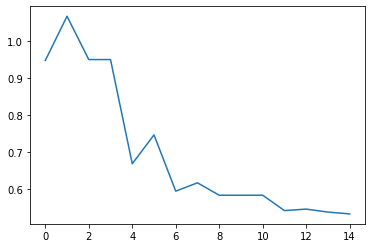

In [42]:
plt.plot(fitness)

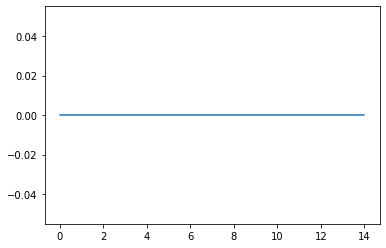

In [43]:
plt.plot(best_h)

In [44]:
def sort_pop (pop, fit):
    fit_vector = [fit(ind, variables, idx2edge, data) for ind in pop]
    rank = np.argsort(fit_vector)
    
    return pop[rank]

In [45]:
sorted_pop = sort_pop(pop, fit_ls)

(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)
(

In [46]:
best = sorted_pop[0]

In [47]:
best_adj = vector_to_adj(sorted_pop[0], variables, idx2edge)

In [48]:
h(best_adj)

0.0

In [49]:
is_connected(best_adj)

False

In [50]:
variables

['S', 'L', 'A', 'T', 'E', 'X', 'B', 'D']

In [51]:
best_adj

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [52]:
gt

array([[0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [64]:
# Create bayesian network from gt
gt_bn = vec2bayesNet(gt_vec)
bic(gt_bn, data)

2276.132497516644

In [68]:
gt_bn.adj

AdjacencyView({'S': {'L': {'weight': None}, 'B': {'weight': None}}, 'L': {'E': {'weight': None}}, 'B': {'D': {'weight': None}}, 'E': {'X': {'weight': None}, 'D': {'weight': None}}, 'A': {'T': {'weight': None}}, 'T': {'E': {'weight': None}}, 'X': {}, 'D': {}})

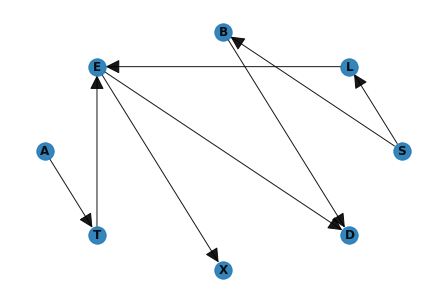

In [66]:
# Display the graph
draw_graph(gt_bn)

In [54]:
least_squares_objective(best_adj, data)

(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)


0.533

In [55]:
least_squares_objective(gt, data)

(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)


0.782

In [56]:
G = nx.fast_gnp_random_graph(len(data.columns), 0.5, directed=True)
G_mat = nx.to_numpy_matrix(G)

In [57]:
G_mat = np.array(G_mat)

In [58]:
least_squares_objective(G_mat, data)

(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)


4.9785

In [59]:
lagrangian(best_adj, data)

(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)


0.533

In [60]:
lagrangian(gt,data)

(1000, 8)
(1000, 8)
(8, 8)
(1000, 8)


0.782

In [61]:
BN = vec2bayesNet(best)

In [62]:
bic(BN, data)

ValueError: Missing columns in data. Can't find values for the following variables: set()

In [ ]:
bic(vec2bayesNet(gt_vec), data)

2255.187394847999

In [ ]:
DG = vector2DiGraph(best)

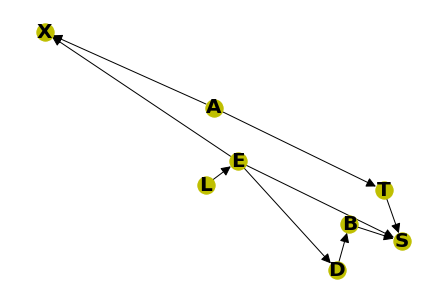

In [ ]:
drawDiGraph (DG)

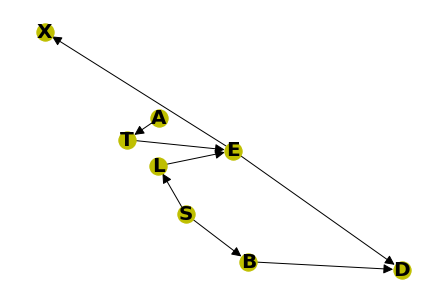

In [ ]:
draw_adj(gt)

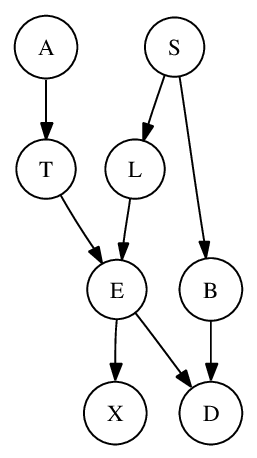

In [ ]:
import numpy as np
import pandas as pd

def compute_bic_score(adj_matrix, data):
    """
    Compute the BIC score for a given DAG and data.

    Parameters:
    - adj_matrix: The adjacency matrix of the DAG (numpy array).
    - data: The dataframe containing the data.

    Returns:
    - bic_score: The computed BIC score.
    """
    n, _ = adj_matrix.shape
    num_params = np.sum(adj_matrix)  # Count the number of parameters (edges)
    log_likelihood = 0.0

    for i in range(n):
        # Get the parents of node i (nodes that have an edge to i)
        parents = np.where(adj_matrix[:, i] == 1)[0]

        if len(parents) == 0:
            # If node i has no parents, calculate the likelihood directly from data
            unique_counts = data.iloc[:, i].value_counts()
            for val, count in unique_counts.items():
                prob = count / len(data)
                log_likelihood += count * np.log(prob)
        else:
            # If node i has parents, calculate conditional probabilities
            parent_data = data.iloc[:, parents]
            if not parent_data.empty:
                joint_data = pd.concat([parent_data, data.iloc[:, i]], axis=1)
                unique_joint_counts = joint_data.groupby(list(joint_data.columns)).size()
                for values, count in unique_joint_counts.items():
                    parent_values = list(values[:-1])  # Convert tuple to list
                    node_value = values[-1]
                    prob = count / len(data.iloc[:, parent_values])  # Use iloc
                    log_likelihood += count * np.log(prob)

    # Calculate BIC score
    bic_score = log_likelihood - 0.5 * num_params * np.log(len(data))

    return bic_score

# Example usage:
# Assuming 'adj_matrix' is the adjacency matrix of the DAG and 'data' is your dataframe
# bic = compute_bic_score(adj_matrix, data)
# print("BIC Score:", bic)


In [ ]:
bic(vec2bayesNet(gt_vec), data)

2255.187394847999

In [ ]:
compute_bic_score(gt, data) / 2

-2543.5129393253505

In [ ]:
import bnlearn as bn

In [ ]:
DAG = bn.make_DAG(vec2bayesNet(best))

[bnlearn] >No changes made to existing bayes DAG.


In [ ]:
bn.bnlearn.structure_scores(DAG, data, scoring_method="bic")

AttributeError: module 'bnlearn.bnlearn' has no attribute 'structure_scores'